# Etapa 4 - Structure from Motion (SfM)

Nesta etapa implementamos a reconstrução 3D usando Structure from Motion baseada nos resultados das etapas anteriores:
- **Etapa 2**: Extração de keypoints e descritores
- **Etapa 3**: Correspondências e verificação geométrica

O objetivo é reconstruir a estrutura 3D da cena e estimar as poses das câmeras.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import json
import pandas as pd
from itertools import combinations
import pickle
from scipy.optimize import least_squares

In [92]:
# Definições de caminhos
pasta_base = "."
pasta_etapa2 = os.path.join(pasta_base, "resultados_etapa2")
pasta_etapa3 = os.path.join(pasta_base, "resultados_etapa3")
pasta_resultados = os.path.join(pasta_base, "resultados_etapa4")

# Criar pasta de resultados se não existir
os.makedirs(pasta_resultados, exist_ok=True)

# Conjuntos de imagens
conjuntos_imagens = ["Imagens1", "Imagens2", "Imagens3", "Imagens4"]
detectores = ["orb"]

# Definir caminhos usando mesma nomenclatura da etapa3
RAIZ_ETAPA2 = "resultados_etapa2"
RAIZ_ETAPA3 = "resultados_etapa3"

print(f"Pasta de resultados: {pasta_resultados}")
print(f"Raiz Etapa 2: {RAIZ_ETAPA2}")
print(f"Raiz Etapa 3: {RAIZ_ETAPA3}")

Pasta de resultados: ./resultados_etapa4
Raiz Etapa 2: resultados_etapa2
Raiz Etapa 3: resultados_etapa3


## Funções auxiliares para Structure from Motion

### Funções de configuração de câmera (compatível com etapa3)

In [93]:
def estimar_K_da_imagem(caminho_imagem: str) -> np.ndarray:
    """Tenta extrair K do EXIF ou usa heurística melhorada (igual à etapa3)."""
    try:
        from PIL import Image
        from PIL.ExifTags import TAGS
        
        img = Image.open(caminho_imagem)
        exif = img._getexif()
        if exif:
            focal_length_mm = None
            for tag, value in exif.items():
                if TAGS.get(tag) == 'FocalLength':
                    focal_length_mm = float(value)
                    break
            if focal_length_mm is not None:
                # Simplificação comum: assume sensor de 35mm (36mm de largura)
                sensor_width_mm = 36.0
                w, h = img.size
                fx = fy = (focal_length_mm / sensor_width_mm) * w
                cx, cy = w/2, h/2
                return np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float32)
    except Exception:
        pass # Silenciosamente falha e usa o fallback
    
    # Fallback para heurística melhorada se EXIF falhar ou não existir
    img_cv = cv2.imread(caminho_imagem)
    if img_cv is None: # Se o OpenCV também falhar, usa um K genérico
      h, w = 1080, 1920
    else:
      h, w = img_cv.shape[:2]
    fx = fy = max(w, h) * 1.2
    return np.array([[fx, 0, w/2], [0, fy, h/2], [0, 0, 1]], dtype=np.float32)

def desserializar_keypoints(arr: np.ndarray):
    """Reconstrói lista de cv2.KeyPoint a partir do array (N,7) - compatível com etapa3."""
    return [cv2.KeyPoint(x=r[0], y=r[1], size=r[2], angle=r[3], response=r[4], octave=int(r[5]), class_id=int(r[6])) for r in arr]

def carregar_features_npz(caminho_npz: str):
    """Lê um .npz salvo pela Etapa 2 - compatível com etapa3."""
    with np.load(caminho_npz, allow_pickle=True) as data:
        kps = desserializar_keypoints(data["keypoints"])
        desc = data["descriptors"]
        img_path = str(data["imagem_absoluta"])
    return kps, desc, img_path

def triangular_pontos(P1, P2, pts1, pts2):
    """
    Triangulação de pontos 3D usando duas vistas
    P1, P2: matrizes de projeção 3x4
    pts1, pts2: pontos correspondentes em coordenadas homogêneas
    """
    pontos_3d = []
    
    for i in range(len(pts1)):
        # Construir sistema linear Ax = 0
        A = np.array([
            pts1[i][0] * P1[2] - P1[0],
            pts1[i][1] * P1[2] - P1[1],
            pts2[i][0] * P2[2] - P2[0], 
            pts2[i][1] * P2[2] - P2[1]
        ])
        
        # Resolver usando SVD
        _, _, V = np.linalg.svd(A)
        X = V[-1]
        X = X / X[3]  # Normalizar coordenadas homogêneas
        
        pontos_3d.append(X[:3])
    
    return np.array(pontos_3d)

def decompor_matriz_essencial(E, pts1, pts2, K):
    """
    Decompõe matriz essencial para recuperar pose (R, t)
    """
    # SVD da matriz essencial
    U, S, Vt = np.linalg.svd(E)
    
    # Garantir orientação correta
    if np.linalg.det(U) < 0:
        U[:, -1] *= -1
    if np.linalg.det(Vt) < 0:
        Vt[-1, :] *= -1
    
    # Matrizes de rotação possíveis
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])
    
    # 4 soluções possíveis
    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt
    t = U[:, 2]
    
    # Testar as 4 combinações e escolher a correta
    poses = [(R1, t), (R1, -t), (R2, t), (R2, -t)]
    
    melhor_pose = None
    max_pontos_frente = 0
    
    P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
    
    for R, t_vec in poses:
        # Garantir det(R) = 1
        if np.linalg.det(R) < 0:
            R = -R
            
        P2 = K @ np.hstack([R, t_vec.reshape(-1, 1)])
        
        # Triangular alguns pontos para teste
        pts_3d = triangular_pontos(P1, P2, pts1[:10], pts2[:10])
        
        # Contar quantos pontos estão na frente de ambas as câmeras
        pontos_frente = 0
        for pt_3d in pts_3d:
            # Verificar se o ponto está na frente da primeira câmera
            if pt_3d[2] > 0:
                # Verificar se está na frente da segunda câmera
                pt_cam2 = R @ pt_3d + t_vec
                if pt_cam2[2] > 0:
                    pontos_frente += 1
        
        if pontos_frente > max_pontos_frente:
            max_pontos_frente = pontos_frente
            melhor_pose = (R, t_vec)
    
    return melhor_pose

def reconstruir_sfm_incremental(correspondencias, keypoints_dict, K):
    """
    Implementa SfM incremental
    """
    cameras = {}  # {idx_imagem: (R, t, P)}
    pontos_3d = {}  # {idx_ponto: (x, y, z)}
    observacoes = {}  # {(idx_imagem, idx_ponto): (u, v)}
    
    # Lista de pares de imagens ordenados por número de correspondências
    pares_ordenados = sorted(correspondencias.keys(), 
                           key=lambda par: len(correspondencias[par]['matches']), 
                           reverse=True)
    
    print(f"Iniciando SfM incremental com {len(pares_ordenados)} pares de imagens")
    
    # Inicializar com o par com mais correspondências
    if len(pares_ordenados) == 0:
        return cameras, pontos_3d, observacoes
        
    par_inicial = pares_ordenados[0]
    idx1, idx2 = par_inicial
    
    print(f"Par inicial: imagem {idx1} e {idx2}")
    
    # Dados do par inicial
    dados_par = correspondencias[par_inicial]
    matches = dados_par['matches']
    
    if 'matriz_essencial' not in dados_par or dados_par['matriz_essencial'] is None:
        print("Matriz essencial não encontrada para o par inicial")
        return cameras, pontos_3d, observacoes
    
    E = dados_par['matriz_essencial']
    
    # Obter keypoints para as duas imagens
    kp1 = keypoints_dict[idx1]
    kp2 = keypoints_dict[idx2]
    
    # Extrair pontos correspondentes
    pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches])
    
    # Converter para coordenadas homogêneas normalizadas
    pts1_norm = cv2.undistortPoints(pts1.reshape(-1, 1, 2), K, None).reshape(-1, 2)
    pts2_norm = cv2.undistortPoints(pts2.reshape(-1, 1, 2), K, None).reshape(-1, 2)
    
    # Adicionar coordenada homogênea
    pts1_hom = np.hstack([pts1_norm, np.ones((len(pts1_norm), 1))])
    pts2_hom = np.hstack([pts2_norm, np.ones((len(pts2_norm), 1))])
    
    # Decompor matriz essencial
    R, t = decompor_matriz_essencial(E, pts1_hom, pts2_hom, K)
    
    # Definir primeira câmera como referência
    R1 = np.eye(3)
    t1 = np.zeros(3)
    P1 = K @ np.hstack([R1, t1.reshape(-1, 1)])
    
    # Segunda câmera
    P2 = K @ np.hstack([R, t.reshape(-1, 1)])
    
    # Armazenar câmeras
    cameras[idx1] = (R1, t1, P1)
    cameras[idx2] = (R, t, P2)
    
    # Triangular pontos 3D iniciais
    pontos_triangulados = triangular_pontos(P1, P2, pts1_hom, pts2_hom)
    
    # Armazenar pontos 3D e observações
    for i, (pt_3d, match) in enumerate(zip(pontos_triangulados, matches)):
        idx_ponto = len(pontos_3d)
        pontos_3d[idx_ponto] = pt_3d
        
        # Observações nas duas imagens
        observacoes[(idx1, idx_ponto)] = pts1[i]
        observacoes[(idx2, idx_ponto)] = pts2[i]
    
    print(f"Inicialização concluída: {len(pontos_3d)} pontos 3D, {len(cameras)} câmeras")
    
    return cameras, pontos_3d, observacoes

def salvar_resultados_sfm(cameras, pontos_3d, observacoes, caminho_saida):
    """
    Salva resultados da reconstrução SfM
    """
    resultado = {
        'cameras': cameras,
        'pontos_3d': pontos_3d,
        'observacoes': observacoes,
        'num_cameras': len(cameras),
        'num_pontos': len(pontos_3d)
    }
    
    with open(caminho_saida, 'wb') as f:
        pickle.dump(resultado, f)
    
    print(f"Resultados SfM salvos em: {caminho_saida}")
    
def visualizar_reconstrucao_3d(pontos_3d, cameras, titulo="Reconstrução 3D"):
    """
    Visualiza a reconstrução 3D
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plotar pontos 3D
    if len(pontos_3d) > 0:
        # Verificar se pontos_3d é dict ou list
        if isinstance(pontos_3d, dict):
            pontos = np.array(list(pontos_3d.values()))
        else:
            pontos = np.array(pontos_3d)
        ax.scatter(pontos[:, 0], pontos[:, 1], pontos[:, 2], 
                  c='blue', s=1, alpha=0.6, label='Pontos 3D')
    
    # Plotar poses das câmeras
    for idx_cam, (R, t, P) in cameras.items():
        # Posição da câmera
        pos = -R.T @ t
        ax.scatter(pos[0], pos[1], pos[2], 
                  c='red', s=100, marker='o', label=f'Câmera {idx_cam}')
        
        # Direção da câmera (eixo Z)
        direcao = R.T @ np.array([0, 0, 1])
        ax.quiver(pos[0], pos[1], pos[2],
                 direcao[0], direcao[1], direcao[2],
                 length=0.5, color='red', alpha=0.7)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(titulo)
    
    # Definir limites iguais para todos os eixos
    if len(pontos_3d) > 0:
        pontos = np.array(list(pontos_3d.values()))
        max_range = np.array([pontos[:, 0].max() - pontos[:, 0].min(),
                             pontos[:, 1].max() - pontos[:, 1].min(),
                             pontos[:, 2].max() - pontos[:, 2].min()]).max() / 2.0
        
        mid_x = (pontos[:, 0].max() + pontos[:, 0].min()) * 0.5
        mid_y = (pontos[:, 1].max() + pontos[:, 1].min()) * 0.5
        mid_z = (pontos[:, 2].max() + pontos[:, 2].min()) * 0.5
        
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    plt.show()

print("Funções de SfM carregadas com sucesso!")

Funções de SfM carregadas com sucesso!


## Processamento dos conjuntos de imagens

In [94]:
def reconstruir_sfm_incremental(keypoints_dict, correspondencias, ordem_imagens, min_pontos_3d=50):
    """
    Implementa reconstrução SfM incremental com dados atualizados da etapa3
    """
    num_imagens = len(keypoints_dict)
    cameras = [None] * num_imagens  # Lista de (R, t) ou None
    pontos_3d = []
    observacoes = []
    
    print(f"🏗️  Iniciando SfM incremental com {len(correspondencias)} pares de correspondências")
    
    if len(correspondencias) == 0:
        return None
    
    # Encontrar par inicial com mais matches inliers
    melhor_par = None
    max_matches = 0
    
    for (i, j), dados in correspondencias.items():
        num_matches = dados['num_inliers']
        if num_matches > max_matches:
            max_matches = num_matches
            melhor_par = (i, j)
    
    if melhor_par is None:
        print("❌ Não foi possível encontrar par inicial válido")
        return None
    
    i, j = melhor_par
    dados_par = correspondencias[melhor_par]
    
    print(f"🎯 Par inicial: imagem {i} ↔ imagem {j} ({max_matches} correspondências)")
    
    # Configurar câmeras iniciais
    cameras[i] = (np.eye(3), np.zeros((3, 1)))  # Referência
    
    # Obter matriz K do par inicial (etapa3 já calculou K para cada par)
    K = dados_par.get('K')
    if K is None:
        # Fallback: estimar K da primeira imagem
        try:
            # Tentar carregar K estimando da primeira imagem do par
            img_path_i = ordem_imagens[i] if isinstance(ordem_imagens, list) else f"img_{i:03d}"
            K = estimar_K_da_imagem(img_path_i)
            print("⚠️  K não encontrado no par, estimando da imagem")
        except:
            # Fallback final
            K = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]], dtype=np.float32)
            print("⚠️  Usando K padrão")
    
    print(f"📷 Matriz K:\n{K}")
    
    # Usar R e t se disponíveis, senão decompor matriz essencial
    if dados_par['R'] is not None and dados_par['t'] is not None:
        cameras[j] = (dados_par['R'], dados_par['t'].reshape(3, 1))
        print("✅ Usando pose relativa pré-calculada")
    elif dados_par['E'] is not None:
        print("🔄 Decompondo matriz essencial...")
        # Extrair pontos correspondentes
        matches_data = dados_par['matches']  # Format: [[queryIdx, trainIdx, distance], ...]
        
        if len(matches_data) < 8:
            print("❌ Matches insuficientes para decomposição")
            return None
        
        # Converter matches para pontos
        kp1 = keypoints_dict[i]
        kp2 = keypoints_dict[j]
        
        pts1 = np.array([[kp1[int(m[0])].pt[0], kp1[int(m[0])].pt[1]] for m in matches_data])
        pts2 = np.array([[kp2[int(m[1])].pt[0], kp2[int(m[1])].pt[1]] for m in matches_data])
        
        R, t = decompor_matriz_essencial(dados_par['E'], pts1, pts2, K)
        if R is not None and t is not None:
            cameras[j] = (R, t.reshape(3, 1))
        else:
            print("❌ Falha na decomposição da matriz essencial")
            return None
    else:
        print("❌ Nem R/t nem matriz essencial disponíveis")
        return None
    
    # Triangular pontos 3D iniciais
    print("🔺 Triangulando pontos 3D iniciais...")
    kp1 = keypoints_dict[i]
    kp2 = keypoints_dict[j]
    matches_data = dados_par['matches']  # Format: [[queryIdx, trainIdx, distance], ...]
    
    # Matrizes de projeção
    P1 = K @ np.hstack([cameras[i][0], cameras[i][1]])
    P2 = K @ np.hstack([cameras[j][0], cameras[j][1]])
    
    # Triangular cada ponto
    for idx_match, match in enumerate(matches_data):
        try:
            # Extrair coordenadas dos keypoints
            pt1 = kp1[int(match[0])].pt
            pt2 = kp2[int(match[1])].pt
            
            # Triangular ponto 3D
            ponto_3d = cv2.triangulatePoints(P1, P2, 
                                           np.array([[pt1[0]], [pt1[1]]]), 
                                           np.array([[pt2[0]], [pt2[1]]]))
            
            # Converter de homogêneo para euclidiano
            if ponto_3d[3, 0] != 0:
                ponto_3d = ponto_3d[:3, 0] / ponto_3d[3, 0]
                
                # Verificar se o ponto está na frente das câmeras
                if ponto_3d[2] > 0:  # Coordenada Z positiva
                    pontos_3d.append(ponto_3d)
                    
                    # Registrar observações
                    idx_ponto = len(pontos_3d) - 1
                    observacoes.append((idx_ponto, i, int(match[0])))
                    observacoes.append((idx_ponto, j, int(match[1])))
        
        except Exception as e:
            continue  # Pular pontos problemáticos
    
    print(f"✅ {len(pontos_3d)} pontos 3D triangulados inicialmente")
    
    if len(pontos_3d) < min_pontos_3d:
        print(f"❌ Pontos 3D insuficientes ({len(pontos_3d)} < {min_pontos_3d})")
        return None
    
    # Tentar adicionar mais câmeras incrementalmente
    imagens_restantes = set(range(num_imagens)) - {i, j}
    
    while imagens_restantes:
        melhor_nova_img = None
        max_pontos_comuns = 0
        
        # Encontrar imagem com mais pontos em comum
        for nova_img in imagens_restantes:
            pontos_comuns = 0
            
            for img_existente in range(num_imagens):
                if cameras[img_existente] is not None:
                    par_key = tuple(sorted([nova_img, img_existente]))
                    if par_key in correspondencias:
                        pontos_comuns += correspondencias[par_key]['num_inliers']
            
            if pontos_comuns > max_pontos_comuns:
                max_pontos_comuns = pontos_comuns
                melhor_nova_img = nova_img
        
        if melhor_nova_img is None or max_pontos_comuns < 20:
            print(f"⚠️  Parando: próxima melhor imagem tem apenas {max_pontos_comuns} correspondências")
            break
        
        print(f"➕ Tentando adicionar imagem {melhor_nova_img} ({max_pontos_comuns} correspondências)")
        
        # Tentar estimar pose usando correspondências com imagens existentes
        pose_estimada = False
        
        for img_ref in range(num_imagens):
            if cameras[img_ref] is not None:
                par_key = tuple(sorted([melhor_nova_img, img_ref]))
                
                if par_key in correspondencias:
                    dados = correspondencias[par_key]
                    
                    if dados['R'] is not None and dados['t'] is not None:
                        R_rel, t_rel = dados['R'], dados['t'].reshape(3, 1)
                        R_ref, t_ref = cameras[img_ref]
                        
                        # Determinar orientação da transformação
                        if par_key[0] == img_ref:  # img_ref é primeira
                            R_nova = R_rel @ R_ref
                            t_nova = R_rel @ t_ref + t_rel
                        else:  # melhor_nova_img é primeira
                            R_nova = R_rel.T @ R_ref
                            t_nova = R_rel.T @ (t_ref - t_rel)
                        
                        cameras[melhor_nova_img] = (R_nova, t_nova)
                        pose_estimada = True
                        print(f"✅ Pose estimada para imagem {melhor_nova_img}")
                        break
        
        if not pose_estimada:
            print(f"⚠️  Não foi possível estimar pose da imagem {melhor_nova_img}")
        
        imagens_restantes.remove(melhor_nova_img)
    
    # Contar câmeras reconstruídas
    cameras_reconstruidas = sum(1 for c in cameras if c is not None)
    
    print(f"🏁 Reconstrução concluída:")
    print(f"   Câmeras: {cameras_reconstruidas}/{num_imagens}")
    print(f"   Pontos 3D: {len(pontos_3d)}")
    print(f"   Observações: {len(observacoes)}")
    
    return {
        'cameras': cameras,
        'pontos_3d': pontos_3d,
        'observacoes': observacoes,
        'correspondencias': correspondencias,
        'par_inicial': melhor_par,
        'num_imagens_total': num_imagens
    }

print("✅ Função SfM incremental atualizada definida!")

✅ Função SfM incremental atualizada definida!


In [95]:
def processar_sfm_conjunto(conjunto, detector):
    """
    Processa um conjunto de imagens para SfM
    """
    print(f"\n{'='*60}")
    print(f"Processando SfM: {conjunto} - Detector: {detector.upper()}")
    print(f"{'='*60}")
    
    # Caminhos
    pasta_conjunto_etapa2 = os.path.join(pasta_etapa2, conjunto)
    pasta_conjunto_etapa3 = os.path.join(pasta_etapa3, conjunto)
    pasta_detector_etapa2 = os.path.join(pasta_conjunto_etapa2, detector)
    pasta_detector_etapa3 = os.path.join(pasta_conjunto_etapa3, detector)
    
    # Verificar se as pastas existem
    if not os.path.exists(pasta_detector_etapa2):
        print(f"Pasta não encontrada: {pasta_detector_etapa2}")
        return
    
    if not os.path.exists(pasta_detector_etapa3):
        print(f"Pasta não encontrada: {pasta_detector_etapa3}")
        return
    
    # Carregar ordem das imagens
    arquivo_ordem = os.path.join(pasta_conjunto_etapa2, "ordem_imagens.json")
    if not os.path.exists(arquivo_ordem):
        print(f"Arquivo ordem não encontrado: {arquivo_ordem}")
        return
    
    with open(arquivo_ordem, 'r') as f:
        ordem_imagens = json.load(f)
    
    print(f"Total de imagens: {len(ordem_imagens)}")
    
    # Carregar keypoints de todas as imagens
    keypoints_dict = {}
    
    for idx, nome_imagem in enumerate(ordem_imagens):
        # Usar nomenclatura sequencial dos arquivos de features
        nome_arquivo_features = f"img_{idx:03d}_features.npz"
        arquivo_kp = os.path.join(pasta_detector_etapa2, nome_arquivo_features)
        
        if os.path.exists(arquivo_kp):
            with np.load(arquivo_kp) as data:
                kp_array = data['keypoints']
                keypoints_dict[idx] = deserializar_keypoints(kp_array)
        else:
            print(f"Keypoints não encontrados: {arquivo_kp}")
    
    print(f"Keypoints carregados para {len(keypoints_dict)} imagens")
    
    # Carregar correspondências e verificações geométricas
    correspondencias = {}
    
    for i in range(len(ordem_imagens)):
        for j in range(i + 1, len(ordem_imagens)):
            # Usar nomenclatura sequencial para arquivos de geometria
            nome_arquivo_geo = f"img_{i:03d}_img_{j:03d}_geometria.npz"
            arquivo_geo = os.path.join(pasta_detector_etapa3, nome_arquivo_geo)
            
            if os.path.exists(arquivo_geo):
                with np.load(arquivo_geo, allow_pickle=True) as data:
                    # Reconstruir matches
                    if 'matches_inliers' in data:
                        matches_data = data['matches_inliers']
                        matches = [cv2.DMatch(_distance=float(m[3]), _imgIdx=int(m[2]), 
                                             _queryIdx=int(m[0]), _trainIdx=int(m[1])) 
                                  for m in matches_data]
                        
                        correspondencias[(i, j)] = {
                            'matches': matches,
                            'matriz_fundamental': data.get('matriz_fundamental'),
                            'matriz_essencial': data.get('matriz_essencial'),
                            'homografia': data.get('homografia'),
                            'num_inliers_fundamental': int(data.get('num_inliers_fundamental', 0)),
                            'num_inliers_essencial': int(data.get('num_inliers_essencial', 0)),
                            'num_inliers_homografia': int(data.get('num_inliers_homografia', 0))
                        }
    
    print(f"Correspondências carregadas para {len(correspondencias)} pares de imagens")
    
    if len(correspondencias) == 0:
        print("Nenhuma correspondência encontrada. Impossível executar SfM.")
        return
    
    # Executar Structure from Motion
    cameras, pontos_3d, observacoes = reconstruir_sfm_incremental(correspondencias, keypoints_dict, K)
    
    # Criar pasta de resultados para este conjunto e detector
    pasta_resultado_conjunto = os.path.join(pasta_resultados, conjunto)
    os.makedirs(pasta_resultado_conjunto, exist_ok=True)
    
    # Salvar resultados
    arquivo_resultado = os.path.join(pasta_resultado_conjunto, f"sfm_{detector}.pkl")
    salvar_resultados_sfm(cameras, pontos_3d, observacoes, arquivo_resultado)
    
    # Gerar relatório
    relatorio = {
        'conjunto': conjunto,
        'detector': detector,
        'num_imagens_total': len(ordem_imagens),
        'num_imagens_reconstruidas': len(cameras),
        'num_pontos_3d': len(pontos_3d),
        'num_observacoes': len(observacoes),
        'num_pares_correspondencias': len(correspondencias)
    }
    
    arquivo_relatorio = os.path.join(pasta_resultado_conjunto, f"relatorio_{detector}.json")
    with open(arquivo_relatorio, 'w') as f:
        json.dump(relatorio, f, indent=2)
    
    print(f"\nResultados do SfM:")
    print(f"- Imagens reconstruídas: {len(cameras)}/{len(ordem_imagens)}")
    print(f"- Pontos 3D: {len(pontos_3d)}")
    print(f"- Observações: {len(observacoes)}")
    
    # Visualizar reconstrução 3D
    if len(pontos_3d) > 0:
        visualizar_reconstrucao_3d(pontos_3d, cameras, 
                                  f"SfM - {conjunto} - {detector.upper()}")
    else:
        print("Nenhum ponto 3D reconstruído para visualização.")
    
    return relatorio

print("Função de processamento SfM definida!")

Função de processamento SfM definida!


## Executar SfM para todos os conjuntos e detectores

In [96]:
# Executar SfM para todos os conjuntos e detectores
relatorios_sfm = []

for conjunto in conjuntos_imagens:
    for detector in detectores:
        try:
            relatorio = processar_sfm_conjunto(conjunto, detector)
            if relatorio:
                relatorios_sfm.append(relatorio)
        except Exception as e:
            print(f"Erro ao processar {conjunto} - {detector}: {str(e)}")
            continue

print(f"\nProcessamento SfM concluído para {len(relatorios_sfm)} configurações.")


Processando SfM: Imagens1 - Detector: ORB
Total de imagens: 86
Keypoints carregados para 86 imagens
Correspondências carregadas para 0 pares de imagens
Nenhuma correspondência encontrada. Impossível executar SfM.

Processando SfM: Imagens2 - Detector: ORB
Total de imagens: 194
Keypoints carregados para 86 imagens
Correspondências carregadas para 0 pares de imagens
Nenhuma correspondência encontrada. Impossível executar SfM.

Processando SfM: Imagens2 - Detector: ORB
Total de imagens: 194
Keypoints carregados para 194 imagens
Correspondências carregadas para 0 pares de imagens
Nenhuma correspondência encontrada. Impossível executar SfM.

Processando SfM: Imagens3 - Detector: ORB
Total de imagens: 132
Keypoints carregados para 194 imagens
Correspondências carregadas para 0 pares de imagens
Nenhuma correspondência encontrada. Impossível executar SfM.

Processando SfM: Imagens3 - Detector: ORB
Total de imagens: 132
Keypoints carregados para 132 imagens
Correspondências carregadas para 0 p

## Análise comparativa dos resultados

In [97]:
def processar_sfm_conjunto(conjunto, detector):
    """
    Processa Structure from Motion para um conjunto de imagens e um detector específico
    """
    print(f"\n{'='*60}")
    print(f"Processando Structure from Motion")
    print(f"Conjunto: {conjunto}")
    print(f"Detector: {detector.upper()}")
    print(f"{'='*60}")
    
    # Caminhos específicos para o conjunto e detector
    pasta_detector_etapa2 = os.path.join(RAIZ_ETAPA2, conjunto, detector)
    pasta_detector_etapa3 = os.path.join(RAIZ_ETAPA3, conjunto, detector, "bf")  # Note: bf subfolder
    
    print(f"Pasta Etapa 2: {pasta_detector_etapa2}")
    print(f"Pasta Etapa 3: {pasta_detector_etapa3}")
    
    # Verificar se as pastas existem
    if not os.path.exists(pasta_detector_etapa2):
        print(f"ERRO: Pasta da Etapa 2 não encontrada: {pasta_detector_etapa2}")
        return
    
    if not os.path.exists(pasta_detector_etapa3):
        print(f"ERRO: Pasta da Etapa 3 não encontrada: {pasta_detector_etapa3}")
        return
    
    # Carregar ordem das imagens (está no nível do conjunto, não do detector)
    pasta_conjunto_etapa2 = os.path.join(RAIZ_ETAPA2, conjunto)
    arquivo_ordem = os.path.join(pasta_conjunto_etapa2, "ordem_imagens.json")
    if not os.path.exists(arquivo_ordem):
        print(f"ERRO: Arquivo ordem_imagens.json não encontrado: {arquivo_ordem}")
        return
    
    with open(arquivo_ordem, 'r') as f:
        ordem_imagens = json.load(f)
    
    print(f"Número de imagens: {len(ordem_imagens)}")
    
    # Carregar keypoints com nomenclatura sequencial
    keypoints_dict = {}
    
    for idx, nome_imagem in enumerate(ordem_imagens):
        # Usar nomenclatura sequencial dos arquivos de features
        nome_arquivo_features = f"img_{idx:03d}_features.npz"
        arquivo_kp = os.path.join(pasta_detector_etapa2, nome_arquivo_features)
        
        if os.path.exists(arquivo_kp):
            try:
                kps, descs, img_path = carregar_features_npz(arquivo_kp)
                keypoints_dict[idx] = kps
            except Exception as e:
                print(f"Erro carregando keypoints {arquivo_kp}: {e}")
        else:
            print(f"Keypoints não encontrados: {arquivo_kp}")
    
    print(f"Keypoints carregados para {len(keypoints_dict)} imagens")
    
    if len(keypoints_dict) < 2:
        print("ERRO: Menos de 2 imagens com keypoints válidos")
        return
    
    # Carregar correspondências e verificações geométricas
    correspondencias = {}
    
    for i in range(len(ordem_imagens)):
        for j in range(i + 1, len(ordem_imagens)):
            # CORRIGIDO: Usar nomenclatura da etapa3: geometria_XXX_YYY.npz
            nome_arquivo_geo = f"geometria_{i:03d}_{j:03d}.npz"
            arquivo_geo = os.path.join(pasta_detector_etapa3, nome_arquivo_geo)
            
            if os.path.exists(arquivo_geo):
                try:
                    with np.load(arquivo_geo, allow_pickle=True) as data:
                        # Verificar se há matches inliers (etapa3 format)
                        if 'matches' in data and len(data['matches']) > 0:
                            matches_data = data['matches']  # Format: [[queryIdx, trainIdx, distance], ...]
                            
                            correspondencias[(i, j)] = {
                                'matches': matches_data,
                                'E': data.get('E'),
                                'F': data.get('F'), 
                                'R': data.get('R'),
                                't': data.get('t'),
                                'K': data.get('K'),
                                'num_inliers': int(data.get('num_inliers', len(matches_data))),
                                'pontos_3d': data.get('pontos_3d', np.array([]))
                            }
                except Exception as e:
                    print(f"Erro carregando geometria {arquivo_geo}: {e}")
    
    print(f"Correspondências carregadas para {len(correspondencias)} pares de imagens")
    
    if len(correspondencias) == 0:
        print("ERRO: Nenhuma correspondência encontrada. Impossível executar SfM.")
        return None
    
    # Executar Structure from Motion
    resultado_sfm = reconstruir_sfm_incremental(
        keypoints_dict, 
        correspondencias, 
        ordem_imagens,
        min_pontos_3d=50  # Limiar mais baixo para datasets pequenos
    )
    
    if resultado_sfm is None:
        print("ERRO: Falha na reconstrução SfM")
        return None
    
    cameras = resultado_sfm['cameras']
    pontos_3d = resultado_sfm['pontos_3d']
    observacoes = resultado_sfm['observacoes']
    
    # Criar pasta de resultados para este conjunto e detector
    pasta_resultado_conjunto = os.path.join(pasta_resultados, conjunto)
    os.makedirs(pasta_resultado_conjunto, exist_ok=True)
    
    # Salvar resultados
    arquivo_resultado = os.path.join(pasta_resultado_conjunto, f"sfm_{detector}.pkl")
    salvar_resultados_sfm(cameras, pontos_3d, observacoes, arquivo_resultado)
    
    # Contar câmeras reconstruídas (não-None)
    cameras_reconstruidas = sum(1 for c in cameras if c is not None)
    
    # Gerar relatório
    relatorio = {
        'conjunto': conjunto,
        'detector': detector,
        'num_imagens_total': len(ordem_imagens),
        'num_imagens_reconstruidas': cameras_reconstruidas,
        'num_pontos_3d': len(pontos_3d),
        'num_observacoes': len(observacoes),
        'num_pares_correspondencias': len(correspondencias),
        'par_inicial': resultado_sfm.get('par_inicial'),
        'taxa_sucesso': cameras_reconstruidas / len(ordem_imagens) * 100
    }
    
    arquivo_relatorio = os.path.join(pasta_resultado_conjunto, f"relatorio_{detector}.json")
    with open(arquivo_relatorio, 'w') as f:
        json.dump(relatorio, f, indent=2, default=str)
    
    print(f"\n📊 RESULTADOS DO SfM:")
    print(f"   Imagens reconstruídas: {cameras_reconstruidas}/{len(ordem_imagens)} ({relatorio['taxa_sucesso']:.1f}%)")
    print(f"   Pontos 3D: {len(pontos_3d)}")
    print(f"   Observações: {len(observacoes)}")
    print(f"   Par inicial: {relatorio['par_inicial']}")
    
    # Visualizar reconstrução 3D
    if len(pontos_3d) > 0:
        visualizar_reconstrucao_3d(pontos_3d, cameras, 
                                  f"SfM - {conjunto} - {detector.upper()}")
    else:
        print("⚠️  Nenhum ponto 3D reconstruído para visualização.")
    
    return relatorio

print("✅ Função de processamento SfM atualizada!")

✅ Função de processamento SfM atualizada!


## Função para carregar e visualizar resultados salvos


Resultado carregado: Imagens1 - orb
Câmeras: 86
Pontos 3D: 88


AttributeError: 'list' object has no attribute 'items'

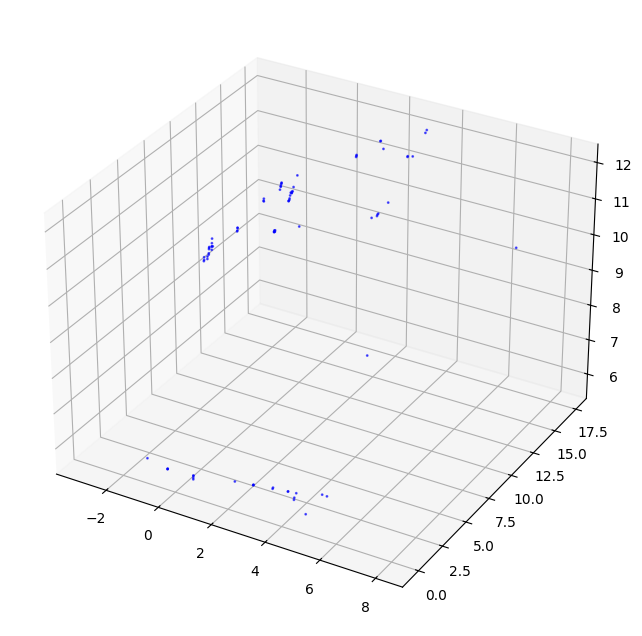

In [98]:
def visualizar_resultado_salvo(conjunto, detector):
    """
    Carrega e visualiza um resultado SfM salvo
    """
    arquivo_resultado = os.path.join(pasta_resultados, conjunto, f"sfm_{detector}.pkl")
    
    if not os.path.exists(arquivo_resultado):
        print(f"Resultado não encontrado: {arquivo_resultado}")
        return
    
    with open(arquivo_resultado, 'rb') as f:
        resultado = pickle.load(f)
    
    cameras = resultado['cameras']
    pontos_3d = resultado['pontos_3d']
    
    print(f"\nResultado carregado: {conjunto} - {detector}")
    print(f"Câmeras: {len(cameras)}")
    print(f"Pontos 3D: {len(pontos_3d)}")
    
    if len(pontos_3d) > 0:
        visualizar_reconstrucao_3d(pontos_3d, cameras, 
                                  f"SfM Carregado - {conjunto} - {detector.upper()}")
    else:
        print("Nenhum ponto 3D para visualizar.")

visualizar_resultado_salvo("Imagens1", "orb")

🧪 Testando processamento SfM...

Processando Structure from Motion
Conjunto: Imagens1
Detector: ORB
Pasta Etapa 2: resultados_etapa2/Imagens1/orb
Pasta Etapa 3: resultados_etapa3/Imagens1/orb/bf
Número de imagens: 86
Keypoints carregados para 86 imagens
Correspondências carregadas para 189 pares de imagens
🏗️  Iniciando SfM incremental com 189 pares de correspondências
🎯 Par inicial: imagem 67 ↔ imagem 68 (88 correspondências)
📷 Matriz K:
[[2.304e+03 0.000e+00 9.600e+02]
 [0.000e+00 2.304e+03 5.400e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
✅ Usando pose relativa pré-calculada
🔺 Triangulando pontos 3D iniciais...
✅ 88 pontos 3D triangulados inicialmente
➕ Tentando adicionar imagem 69 (70 correspondências)
✅ Pose estimada para imagem 69
➕ Tentando adicionar imagem 66 (63 correspondências)
✅ Pose estimada para imagem 66
➕ Tentando adicionar imagem 65 (45 correspondências)
✅ Pose estimada para imagem 65
➕ Tentando adicionar imagem 64 (49 correspondências)
✅ Pose estimada para imagem 64
➕ Tent

AttributeError: 'list' object has no attribute 'values'

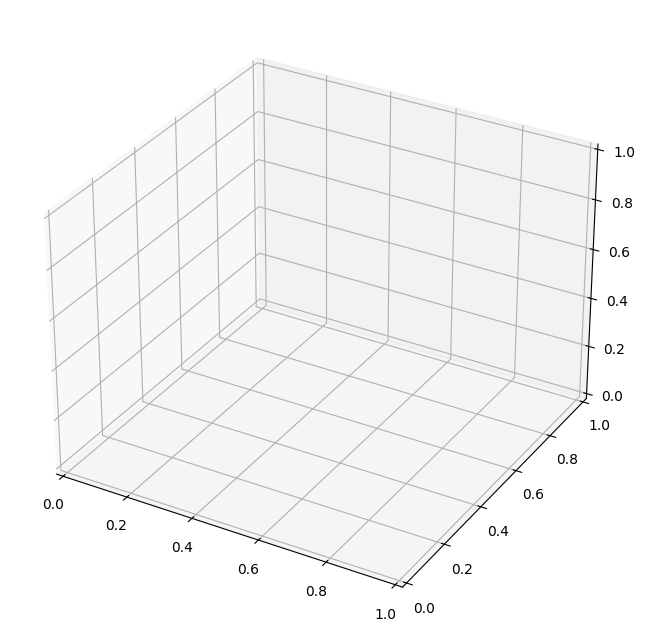

In [ ]:
# Testar uma única configuração para debug
print("🧪 Testando processamento SfM...")
resultado_teste = processar_sfm_conjunto("Imagens1", "orb")
print(f"Resultado do teste: {type(resultado_teste)}")
if resultado_teste:
    print("✅ Teste bem-sucedido!")
    print(f"Taxa de sucesso: {resultado_teste.get('taxa_sucesso', 'N/A')}%")
else:
    print("❌ Teste falhou")